In [1]:
##===== 1. DATA LOADING AND INITIAL EXPLORATION =====
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FAERS_Clean") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()


In [2]:
spark.sparkContext.master

'local[*]'

In [3]:
df = spark.read \
    .option("header", True) \
    .option("delimiter", "$") \
    .option("inferSchema", True) \
    .csv("blood_cholesterol_increased.csv")

In [4]:
df.printSchema()
df.show(5, truncate=False)

root
 |-- age: double (nullable = true)
 |-- age_cod: string (nullable = true)
 |-- age_grp: string (nullable = true)
 |-- age_in_years: double (nullable = true)
 |-- caseid: integer (nullable = true)
 |-- country_code: string (nullable = true)
 |-- death_dt: string (nullable = true)
 |-- dechal: string (nullable = true)
 |-- dose_amt: string (nullable = true)
 |-- dose_form: string (nullable = true)
 |-- dose_freq: string (nullable = true)
 |-- dose_unit: string (nullable = true)
 |-- dose_vbm: string (nullable = true)
 |-- drug_seq: integer (nullable = true)
 |-- drugname: string (nullable = true)
 |-- dur: string (nullable = true)
 |-- dur_cod: string (nullable = true)
 |-- end_dt: double (nullable = true)
 |-- event_dt: double (nullable = true)
 |-- exp_dt: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- indi_hlgt_name: string (nullable = true)
 |-- indi_hlt_name: string (nullable = true)
 |-- indi_llt_name: string (nullable = true)
 |-- indi_meddra_hierarchy_fr

In [10]:
# ===== 2. DATA QUALITY ASSESSMENT =====

## Calculate missing value percentages
from pyspark.sql.functions import col

def count_missing(df):
    total = df.count()
    result = []

    for c in df.columns:
        missing = df.filter(
            col(c).cast("string").isNull() |
            (col(c).cast("string") == "") |
            (col(c).cast("string") == "Not available")
        ).count()

        pct = (missing / total) * 100
        result.append((c, missing, pct))

    # Sort by missing percentage (descending)
    result_sorted = sorted(result, key=lambda x: x[2], reverse=True)
    return result_sorted


In [11]:
missing_stats = count_missing(df)

### Show top 10
for c, m, pct in missing_stats[:10]:
    print(f"{c:35s} missing: {m:7d}   pct: {pct:6.2f}%")

death_dt                            missing:  931686   pct: 100.00%
exp_dt                              missing:  921474   pct:  98.90%
dur_cod                             missing:  899908   pct:  96.59%
dur                                 missing:  898887   pct:  96.48%
to_mfr                              missing:  809220   pct:  86.86%
age_grp                             missing:  785155   pct:  84.27%
end_dt                              missing:  760311   pct:  81.61%
rechal                              missing:  684123   pct:  73.43%
dechal                              missing:  635401   pct:  68.20%
dose_freq                           missing:  624835   pct:  67.06%


In [12]:
# ===== 3. DATA CLEANING =====

## Remove columns with >80% missing values 
from pyspark.sql.functions import col

def missing_percentage(df):
    total = df.count()
    result = []

    for c in df.columns:
        missing = df.filter(
            col(c).cast("string").isNull() |
            (col(c).cast("string") == "") |
            (col(c).cast("string") == "Not available")
        ).count()

        pct = (missing / total) * 100
        result.append((c, missing, pct))

    return result


In [13]:
def remove_high_missing(df, threshold=80):
    stats = missing_percentage(df)

    cols_to_drop = [c for c, miss, pct in stats if pct > threshold]
    cols_to_keep = [c for c, miss, pct in stats if pct <= threshold]

    print(f"Columns removed ({len(cols_to_drop)}):")
    for c in cols_to_drop:
        print(f"  - {c}")

    # return cleaned DataFrame
    return df.select(cols_to_keep)


In [14]:
df_cleaned = remove_high_missing(df, threshold=80)


Columns removed (7):
  - age_grp
  - death_dt
  - dur
  - dur_cod
  - end_dt
  - exp_dt
  - to_mfr


In [15]:
stats = missing_percentage(df)
stats_sorted = sorted(stats, key=lambda x: x[2], reverse=True)

print("\nTop 10 columns by missing%:")
for c, miss, pct in stats_sorted[:10]:
    print(f"{c:30s}  missing: {miss:7d}  pct: {pct:6.2f}%")



Top 10 columns by missing%:
death_dt                        missing:  931686  pct: 100.00%
exp_dt                          missing:  921474  pct:  98.90%
dur_cod                         missing:  899908  pct:  96.59%
dur                             missing:  898887  pct:  96.48%
to_mfr                          missing:  809220  pct:  86.86%
age_grp                         missing:  785155  pct:  84.27%
end_dt                          missing:  760311  pct:  81.61%
rechal                          missing:  684123  pct:  73.43%
dechal                          missing:  635401  pct:  68.20%
dose_freq                       missing:  624835  pct:  67.06%


In [16]:
# Handle remaining nulls strategically
from pyspark.sql.types import StringType, NumericType

# Identify categorical (string) columns
categorical_cols = [c for c, t in df_cleaned.dtypes if t == "string"]

# Identify numeric columns (int, double, float, etc.)
numeric_cols = [c for c, t in df_cleaned.dtypes if t not in ["string"]]
print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


Categorical columns: ['age_cod', 'country_code', 'dechal', 'dose_amt', 'dose_form', 'dose_freq', 'dose_unit', 'dose_vbm', 'drugname', 'gender', 'indi_hlgt_name', 'indi_hlt_name', 'indi_llt_name', 'indi_meddra_hierarchy_from', 'indi_meddra_pt', 'indi_pt', 'indi_pt_name', 'indi_soc_name', 'occr_country', 'outc_cod', 'prod_ai', 'pt', 'quarter', 'reac_hlgt_name', 'reac_hlt_name', 'reac_llt_name', 'reac_meddra_hierarchy_from', 'reac_meddra_pt', 'reac_soc_name', 'rechal', 'reporter_country', 'sex', 'wt_cod']
Numeric columns: ['age', 'age_in_years', 'caseid', 'drug_seq', 'event_dt', 'primaryid', 'start_dt', 'wt', 'year']


In [17]:
from pyspark.sql.functions import when, col

df_filled_cat = df_cleaned

for c in categorical_cols:
    df_filled_cat = df_filled_cat.withColumn(
        c,
        when(col(c).isNull(), "Unknown")
        .when(col(c) == "", "Unknown")
        .when(col(c) == "Not available", "Unknown")
        .otherwise(col(c))
    )


In [18]:
from pyspark.sql.functions import expr

df_filled_num = df_filled_cat

for c in numeric_cols:
    # median requires safe casting
    numeric_col = expr(f"try_cast({c} as double)")
    
    # compute median
    median_val = df_filled_cat.selectExpr(
        f"percentile_approx(try_cast({c} as double), 0.5)"
    ).collect()[0][0]
    
    # skip if median is null (meaning column is mostly non-numeric)
    if median_val is None:
        print(f"Skipping column {c} — not numeric or can't compute median")
        continue
    
    df_filled_num = df_filled_num.withColumn(
        c,
        when(numeric_col.isNull(), median_val).otherwise(numeric_col)
    )


In [19]:
df_final = df_filled_num


In [27]:
# ===== 4. FEATURE ENGINEERING =====

## Create age groups and severity indicator from outcome code
from pyspark.sql.functions import col, when, expr

df_fe = df_cleaned.withColumn(
    "age_num",
    expr("try_cast(age_in_years as double)")
)


In [28]:
df_fe = df_fe.withColumn(
    "age_category",
    when(col("age_num") < 30, "18-30")
    .when((col("age_num") >= 31) & (col("age_num") <= 45), "31-45")
    .when((col("age_num") >= 46) & (col("age_num") <= 60), "46-60")
    .when((col("age_num") >= 61) & (col("age_num") <= 75), "61-75")
    .when(col("age_num") > 75, "75+")
    .otherwise("Unknown")
)


In [29]:
df_fe = df_fe.withColumn(
    "severity",
    when(col("outc_cod").cast("string").contains("DE"), "Fatal")
    .when(col("outc_cod").cast("string").contains("LT"), "Life-Threatening")
    .when(col("outc_cod").cast("string").contains("HO"), "Hospitalization")
    .when(col("outc_cod").cast("string").contains("RI"), "Required Intervention")
    .otherwise("Other")
)


In [30]:
df_engineered = df_fe
df_engineered.show(10, truncate=False)


+----+-------+------------+-------+------------+------+-------------+-------------+-------------+-------------+--------+----------+--------+-----------+------+--------------+--------------------+---------------------------+--------------------------+---------------------------+---------------------------+---------------------------+--------------+-------------+--------+---------+-------------+--------------------+-------+---------------------------------------------------+---------------------------------------------------------+--------------------+--------------------------+--------------------+----------------------------------------------------+------+----------------+------+-----------+-----+------+----+-------+------------+----------------+
|age |age_cod|age_in_years|caseid |country_code|dechal|dose_amt     |dose_form    |dose_freq    |dose_unit    |dose_vbm|drug_seq  |drugname|event_dt   |gender|indi_hlgt_name|indi_hlt_name       |indi_llt_name              |indi_meddra_hierarch

In [34]:
# ===== 5. DESCRIPTIVE ANALYSIS =====
from pyspark.sql.functions import col


### 1. Age distribution
df_engineered.groupBy("age_category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(truncate=False)

### 2. Gender distribution
df_engineered.groupBy(col("sex").cast("string")) \
    .count() \
    .orderBy(col("count").desc()) \
    .show(truncate=False)

### 3. Outcome / severity distribution
df_engineered.groupBy("severity") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(truncate=False)


+------------+------+
|age_category|count |
+------------+------+
|61-75       |312129|
|46-60       |226717|
|Unknown     |178043|
|75+         |170167|
|31-45       |41047 |
|18-30       |3583  |
+------------+------+

+------+------+
|sex   |count |
+------+------+
|Female|520823|
|Male  |369097|
|NULL  |41766 |
+------+------+

+---------------------+------+
|severity             |count |
+---------------------+------+
|Other                |665785|
|Hospitalization      |197482|
|Fatal                |34389 |
|Life-Threatening     |29782 |
|Required Intervention|4248  |
+---------------------+------+



In [35]:
### 1. Most common adverse reactions (PT)
from pyspark.sql.functions import col, upper, trim

df_engineered = df_engineered.withColumn(
    "pt_norm",
    upper(trim(col("pt")))
)

df_engineered.groupBy("pt_norm") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(20, truncate=False)

+----------------------------------------+-----+
|pt_norm                                 |count|
+----------------------------------------+-----+
|MYALGIA                                 |11857|
|FATIGUE                                 |10744|
|DRUG INEFFECTIVE                        |10659|
|NAUSEA                                  |10079|
|PAIN                                    |9819 |
|PAIN IN EXTREMITY                       |9462 |
|ARTHRALGIA                              |9378 |
|TYPE 2 DIABETES MELLITUS                |9125 |
|DYSPNOEA                                |8712 |
|OFF LABEL USE                           |8026 |
|HEADACHE                                |7999 |
|WRONG TECHNIQUE IN PRODUCT USAGE PROCESS|7995 |
|DIZZINESS                               |7781 |
|DEVICE DIFFICULT TO USE                 |7596 |
|ASTHENIA                                |7527 |
|DIARRHOEA                               |7452 |
|BLOOD CHOLESTEROL INCREASED             |7271 |
|FLUSHING           

In [36]:
# ===== 6. DRUG-REACTION ASSOCIATION ANALYSIS =====
###Add drugname normalization first
from pyspark.sql.functions import upper, trim, col, desc

df_engineered = df_engineered.withColumn(
    "drugname_norm",
    upper(trim(col("drugname")))
)


In [37]:
###Most common Drug × Reaction pairs
drug_reaction_pairs = (
    df_engineered.groupBy("drugname_norm", "pt_norm")
    .count()
    .orderBy(desc("count"))
    .limit(20)
)

print("\nTop Drug–Reaction Associations:")
drug_reaction_pairs.show(truncate=False)



Top Drug–Reaction Associations:
+-------------+----------------------------------------+-----+
|drugname_norm|pt_norm                                 |count|
+-------------+----------------------------------------+-----+
|REPATHA      |DEVICE DIFFICULT TO USE                 |7488 |
|REPATHA      |WRONG TECHNIQUE IN PRODUCT USAGE PROCESS|6834 |
|LIPITOR      |TYPE 2 DIABETES MELLITUS                |6708 |
|REPATHA      |DRUG DOSE OMISSION BY DEVICE            |5774 |
|REPATHA      |ACCIDENTAL EXPOSURE TO PRODUCT          |3881 |
|NIASPAN      |FLUSHING                                |3746 |
|REPATHA      |INJECTION SITE PAIN                     |2687 |
|LIPITOR      |MYALGIA                                 |2454 |
|CRESTOR      |MYALGIA                                 |1890 |
|LIPITOR      |DRUG INEFFECTIVE                        |1821 |
|REPATHA      |DRUG DOSE OMISSION                      |1776 |
|LIPITOR      |PAIN IN EXTREMITY                       |1761 |
|ATORVASTATIN |CHRONIC

In [38]:
###Function: Reactions by a specific drug
def reactions_by_drug(df, drug_name):
    drug_upper = drug_name.upper()
    return (
        df.filter(col("drugname_norm").contains(drug_upper))
          .groupBy("pt_norm")
          .count()
          .orderBy(desc("count"))
    )


In [39]:
###Example: analyze LIPITOR
lipitor_reactions = reactions_by_drug(df_engineered, "LIPITOR")

print("\nReactions for LIPITOR:")
lipitor_reactions.show(10, truncate=False)



Reactions for LIPITOR:
+---------------------------+-----+
|pt_norm                    |count|
+---------------------------+-----+
|TYPE 2 DIABETES MELLITUS   |6709 |
|MYALGIA                    |2463 |
|DRUG INEFFECTIVE           |1826 |
|PAIN IN EXTREMITY          |1775 |
|PAIN                       |1619 |
|ARTHRALGIA                 |1514 |
|FATIGUE                    |1469 |
|BLOOD CHOLESTEROL INCREASED|1448 |
|ASTHENIA                   |1312 |
|MUSCLE SPASMS              |1196 |
+---------------------------+-----+
only showing top 10 rows


In [42]:
# ===== 7. DEMOGRAPHIC RISK ANALYSIS =====

### Serious outcomes by age group
from pyspark.sql.functions import col, round

serious_by_age = (
    df_engineered
    .filter(col("severity").isin(["Fatal", "Life-Threatening", "Hospitalization"]))
    .groupBy("age_category")
    .count()
    .orderBy("age_category")
)

print("\nSerious Outcomes by Age Category:")
serious_by_age.show()



Serious Outcomes by Age Category:
+------------+-----+
|age_category|count|
+------------+-----+
|       18-30| 1257|
|       31-45|11458|
|       46-60|62295|
|       61-75|79897|
|         75+|63438|
|     Unknown|43308|
+------------+-----+



In [41]:
total_serious = df_engineered.filter(
    col("severity").isin(["Fatal", "Life-Threatening", "Hospitalization"])
).count()

serious_by_gender = (
    df_engineered
    .filter(col("severity").isin(["Fatal", "Life-Threatening", "Hospitalization"]))
    .groupBy("gender")
    .count()
    .withColumn("percentage", round((col("count") / total_serious) * 100, 2))
)

print("\nSerious Outcomes by Gender:")
serious_by_gender.show()


Serious Outcomes by Gender:
+------+------+----------+
|gender| count|percentage|
+------+------+----------+
|    NS|   180|      0.07|
|     F|129200|     49.38|
|  NULL| 13041|      4.98|
|     M|119226|     45.57|
|   UNK|     6|       0.0|
+------+------+----------+



In [44]:
# ===== 9. VISUALIZATION (Convert to Pandas for plotting) =====
from pyspark.sql.functions import lower

top_reactions = (
    df_engineered
    .withColumn("pt_lower", lower(col("indi_pt")))
    .groupBy("pt_lower")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
    .withColumnRenamed("pt_lower", "pt")
)
age_distribution = (
    df_engineered
    .groupBy("age_category")
    .count()
    .orderBy("age_category")
)
outcome_distribution = (
    df_engineered
    .groupBy("severity")
    .count()
    .orderBy(col("count").desc())
)


In [45]:
top_reactions_pd = top_reactions.toPandas()
age_distribution_pd = age_distribution.toPandas()
outcome_distribution_pd = outcome_distribution.toPandas()


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns



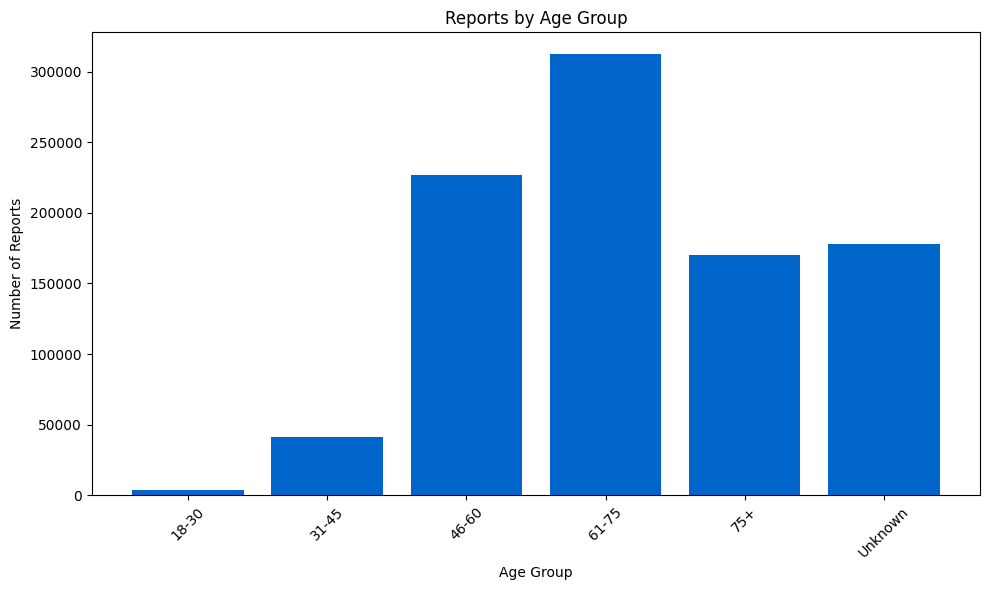

In [50]:
plt.figure(figsize=(10, 6))
plt.bar(age_distribution_pd['age_category'], age_distribution_pd['count'], color='#0066CC')
plt.xlabel('Age Group')
plt.ylabel('Number of Reports')
plt.title('Reports by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


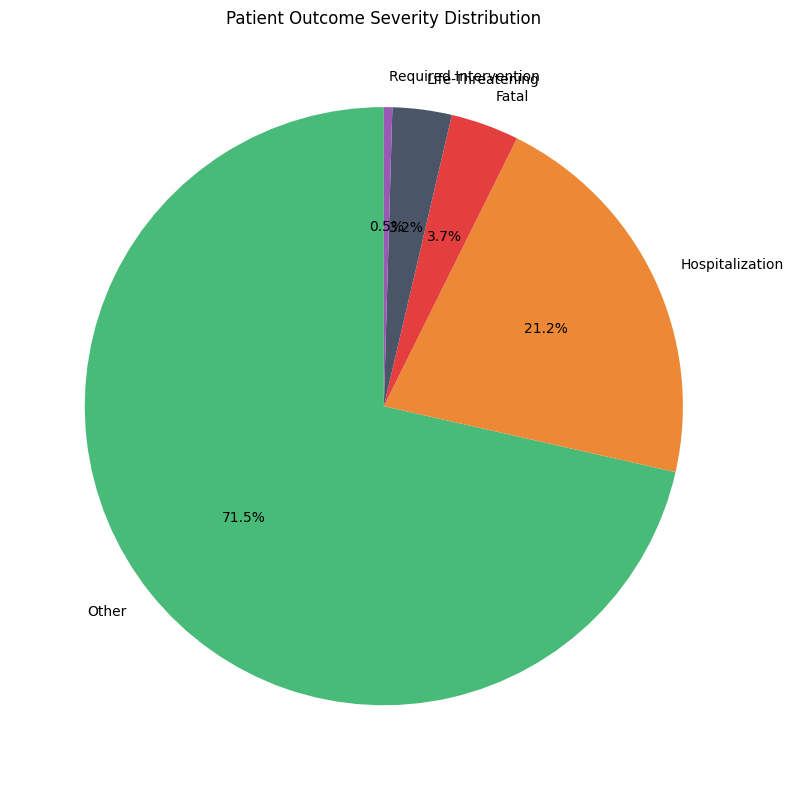

In [51]:
plt.figure(figsize=(10, 8))
colors = ['#48BB78', '#ED8936', '#E53E3E', '#4A5568', '#9B59B6']

plt.pie(
    outcome_distribution_pd['count'],
    labels=outcome_distribution_pd['severity'],
    autopct='%1.1f%%',
    colors=colors[:len(outcome_distribution_pd)],
    startangle=90
)

plt.title('Patient Outcome Severity Distribution')
plt.tight_layout()
plt.savefig('outcome_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [52]:
from pyspark.sql.functions import col, upper, trim, desc

top_reactions = (
    df_engineered
    .withColumn("reaction_pt", upper(trim(col("reac_meddra_pt"))))
    .groupBy("reaction_pt")
    .count()
    .orderBy(desc("count"))
    .limit(10)
)

top_reactions.show(truncate=False)


+------------------------+-----+
|reaction_pt             |count|
+------------------------+-----+
|MYALGIA                 |11857|
|FATIGUE                 |10744|
|DRUG INEFFECTIVE        |10659|
|NAUSEA                  |10079|
|PAIN                    |9819 |
|PAIN IN EXTREMITY       |9462 |
|ARTHRALGIA              |9378 |
|TYPE 2 DIABETES MELLITUS|9125 |
|DYSPNOEA                |8712 |
|OFF LABEL USE           |8026 |
+------------------------+-----+



In [53]:
top_reactions_pd = top_reactions.toPandas()


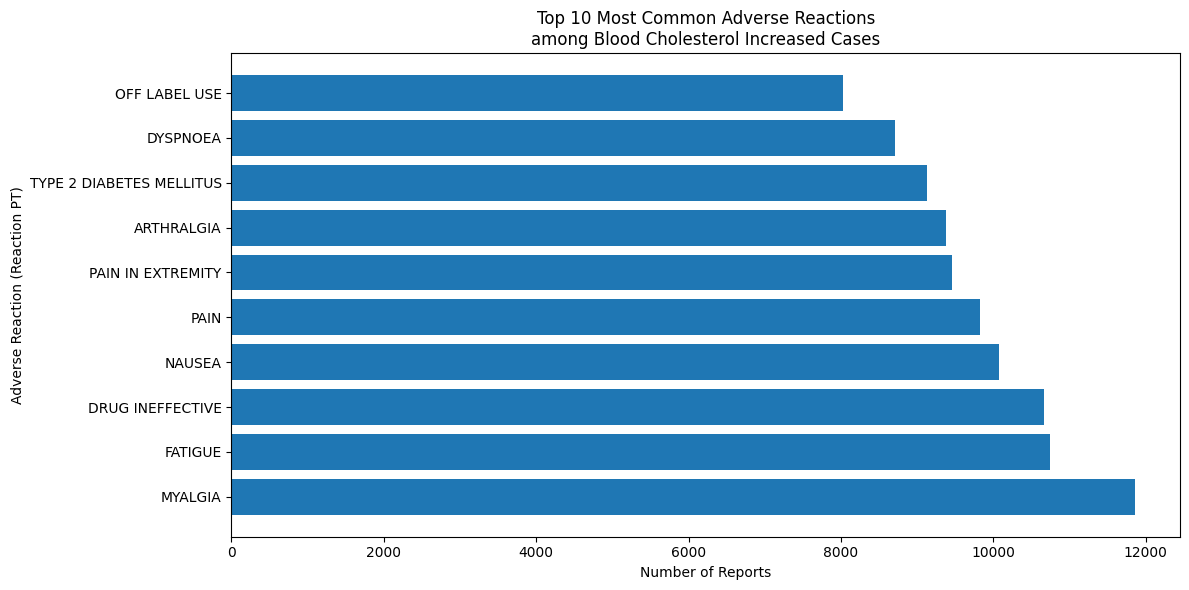

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(12, 6))
plt.barh(top_reactions_pd['reaction_pt'], top_reactions_pd['count'])
plt.xlabel('Number of Reports')
plt.ylabel('Adverse Reaction (Reaction PT)')
plt.title('Top 10 Most Common Adverse Reactions\namong Blood Cholesterol Increased Cases')
plt.tight_layout()
plt.show()


In [56]:
# ===== 10. STATISTICAL SUMMARY =====
from pyspark.sql.functions import col, min, max

summary_stats = {
    "Total Records": df_engineered.count(),
    "Unique Patients": df_engineered.select("primaryid").distinct().count(),
    "Unique Drugs": df_engineered.select("drugname").distinct().count(),
    "Unique Reactions (PT)": df_engineered.select("reac_meddra_pt").distinct().count(),
    "Date Range (event_dt as string)": {
        "Min": df_engineered.agg(min("event_dt")).collect()[0][0],
        "Max": df_engineered.agg(max("event_dt")).collect()[0][0]
    }
}

print("\n===== SUMMARY STATISTICS =====")
for key, value in summary_stats.items():
    print(f"{key}: {value}")



===== SUMMARY STATISTICS =====
Total Records: 931686
Unique Patients: 151230
Unique Drugs: 2806
Unique Reactions (PT): 7947
Date Range (event_dt as string): {'Min': 1962.0, 'Max': 20240626.0}


In [57]:
# compare US and Internitionial
from pyspark.sql.functions import when, col, upper

df_country = df_engineered.withColumn(
    "report_origin",
    when(upper(col("reporter_country")) == "US", "US")
    .when(
        (col("reporter_country").isNull()) |
        (col("reporter_country") == "") |
        (col("reporter_country") == "Not available"),
        "Unknown"
    )
    .otherwise("International")
)


In [58]:
country_summary = (
    df_country.groupBy("report_origin")
    .count()
    .orderBy("report_origin")
)

country_summary.show(truncate=False)


+-------------+------+
|report_origin|count |
+-------------+------+
|International|460780|
|US           |441938|
|Unknown      |28968 |
+-------------+------+



In [64]:
from pyspark.sql.functions import col, when, upper, trim

df_vis = df_engineered.withColumn(
    "outcome_category",
    when(col("outc_cod").isNull(), "Other/Unknown")
    .when(trim(upper(col("outc_cod"))) == "", "Other/Unknown")
    .when(trim(upper(col("outc_cod"))) == "NOT AVAILABLE", "Other/Unknown")
    .when(upper(col("outc_cod")).contains("HO"), "Hospitalization")
    .when(
        upper(col("outc_cod")).contains("DE") |
        upper(col("outc_cod")).contains("LT"),
        "Death/Life-Threatening"
    )
    .when(
        upper(col("outc_cod")).contains("RI") |
        upper(col("outc_cod")).contains("DS"),
        "Need_intervention/Disability"
    )
    .otherwise("Other/Unknown")
)


In [68]:
from pyspark.sql.functions import count
from pyspark.sql.functions import round as spark_round


# Count categories
outcome_counts = (
    df_vis.groupBy("outcome_category")
    .agg(count("*").alias("count"))
)

# Convert to Pandas
outcome_pd = outcome_counts.toPandas()

total = outcome_pd["count"].sum()

# Ensure ordering
categories = [
    "Need_intervention/Disability",
    "Hospitalization",
    "Death/Life-Threatening",
    "Other/Unknown"
]

# Extract values in correct order
values = [int(outcome_pd[outcome_pd['outcome_category'] == c]['count'].sum()) for c in categories]

# Percentages
percentages = [int((v / total) * 100) for v in values]





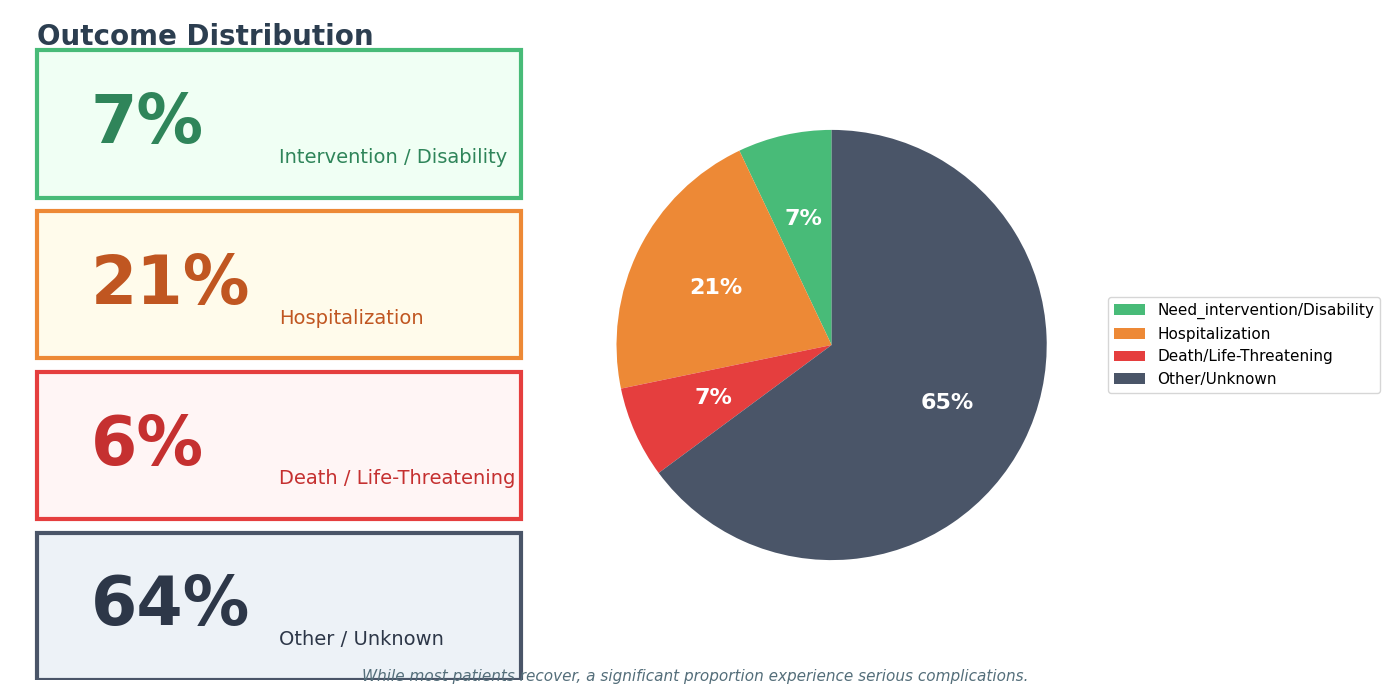


=== OUTCOME SUMMARY ===
Need_intervention/Disability: 65,724 (7%)
Hospitalization: 197,482 (21%)
Death/Life-Threatening: 64,171 (6%)
Other/Unknown: 604,309 (64%)

Total Reports: 931,686


In [73]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#48BB78', '#ED8936', '#E53E3E', '#4A5568']

fig = plt.figure(figsize=(14, 7))

# LEFT SIDE — Info Boxes
ax_left = plt.subplot(1, 2, 1)
ax_left.axis('off')

def draw_box(y, color_bg, color_edge, pct, label, color_text):
    box = plt.Rectangle((0.05, y), 0.9, 0.22,
                        facecolor=color_bg,
                        edgecolor=color_edge,
                        linewidth=3,
                        transform=ax_left.transAxes)
    ax_left.add_patch(box)
    ax_left.text(0.15, y + 0.11, f'{pct}%', transform=ax_left.transAxes,
                 fontsize=48, fontweight='bold', color=color_text, va='center')
    ax_left.text(0.5, y + 0.06, label, transform=ax_left.transAxes,
                 fontsize=14, color=color_text, va='center')

draw_box(0.72, '#F0FFF4', '#48BB78', percentages[0], 'Intervention / Disability', '#2F855A')
draw_box(0.48, '#FFFBEB', '#ED8936', percentages[1], 'Hospitalization', '#C05621')
draw_box(0.24, '#FFF5F5', '#E53E3E', percentages[2], 'Death / Life-Threatening', '#C53030')
draw_box(0.00, '#EDF2F7', '#4A5568', percentages[3], 'Other / Unknown', '#2D3748')

ax_left.text(0.05, 0.98, 'Outcome Distribution', transform=ax_left.transAxes,
             fontsize=20, fontweight='bold', color='#2C3E50', va='top')

# RIGHT SIDE — Pie Chart
ax_right = plt.subplot(1, 2, 2)

wedges, texts, autotexts = ax_right.pie(
    values,
    labels=None,
    autopct='%1.0f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 16, 'fontweight': 'bold', 'color': 'white'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(16)

ax_right.legend(
    wedges,
    categories,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=11
)

fig.text(0.5, 0.02,
         'While most patients recover, a significant proportion experience serious complications.',
         ha='center', fontsize=11, style='italic', color='#546E7A')

plt.tight_layout()
plt.savefig("faers_outcome_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n=== OUTCOME SUMMARY ===")
for cat, val, pct in zip(categories, values, percentages):
    print(f"{cat}: {val:,} ({pct}%)")

print(f"\nTotal Reports: {total:,}")
